## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error




In [2]:
data=pd.read_csv('/content/exchange_rate.csv')

In [3]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


Transforming the 'date' column into datetime format and setting as index

In [5]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')
data.set_index('date', inplace=True)

In [6]:
data

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


## Visualizations

### Plotting the Timeseries for Exploration

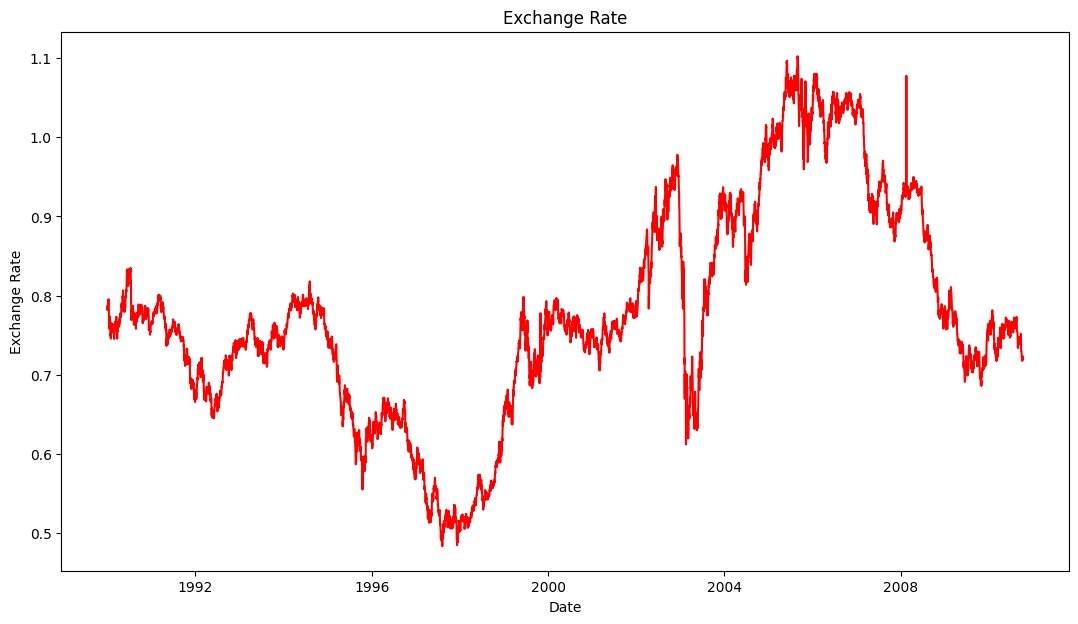

In [8]:
fig=plt.figure(figsize=(13,7))
plt.plot(data["Ex_rate"],color="red")
plt.title("Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()

<Axes: xlabel='date'>

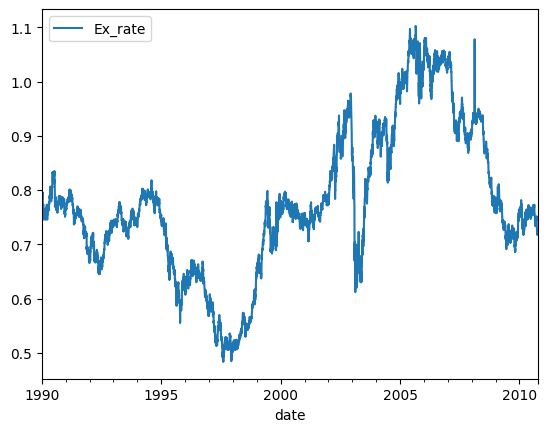

In [9]:
data.plot()

<Axes: ylabel='Density'>

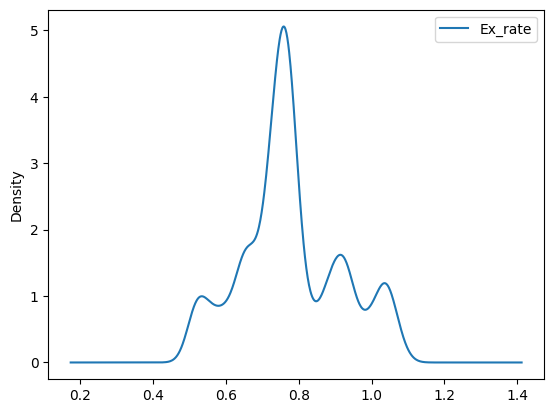

In [10]:
data.plot(kind="kde")

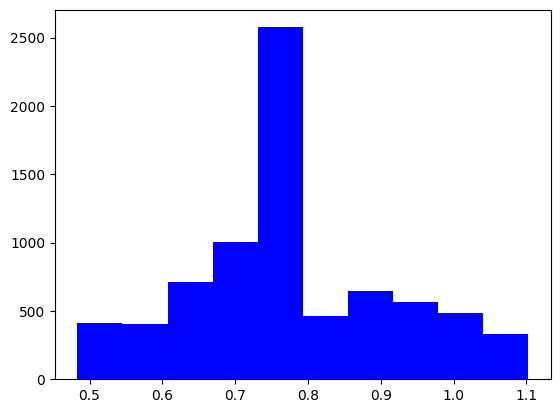

In [11]:
plt.hist(data,color="blue")
plt.show()

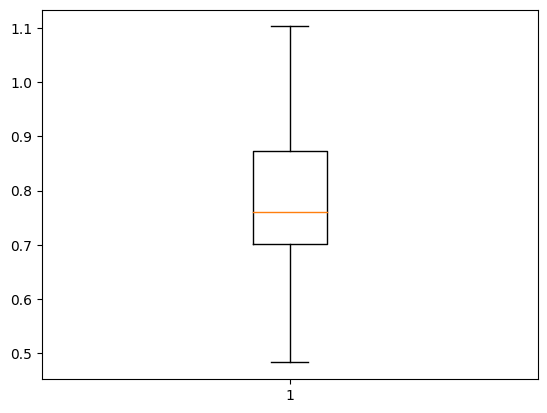

In [12]:
plt.boxplot(data)
plt.show()

### Checking for Null values

In [13]:
data.isnull().sum()

,0
Ex_rate,0


In [14]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


### Perform the Augmented Dickey-Fuller test to check for Stationarity

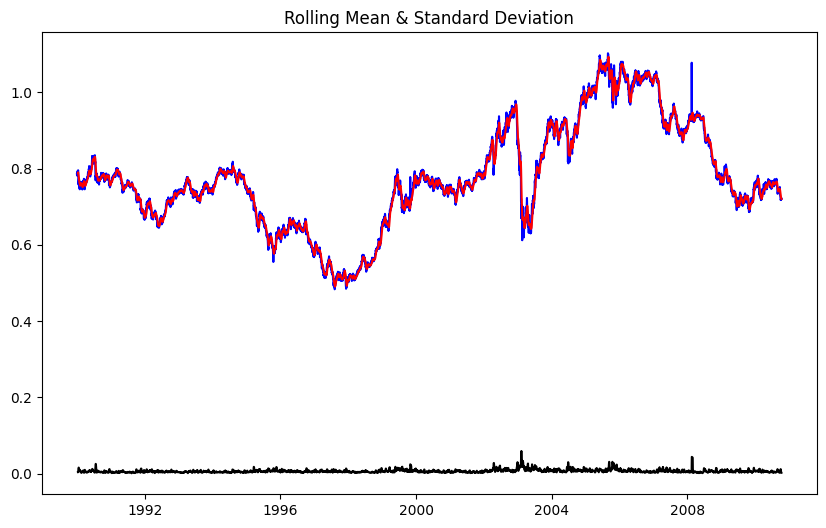

(-1.6649941807382342,
 0.4492327353597477,
 1,
 7586,
 {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108},
 -55835.06254628545)

In [15]:

adf_test_result = adfuller(data['Ex_rate'])


rolling_mean = data['Ex_rate'].rolling(window=12).mean()
rolling_std = data['Ex_rate'].rolling(window=12).std()


plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


adf_test_result


In [16]:
print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])

ADF Statistic: -1.664994
p-value: 0.449233


p-value is greater than 0.05 showing non-stationarity.It should be converted into stationarity


### Applying Log Transformation

In [17]:

exchange_rate_log = np.log(data['Ex_rate'])


In [18]:
# Apply first-order differencing to the log-transformed series (d=1)
exchange_rate_log_diff = exchange_rate_log.diff().dropna()


In [19]:
adf_test_result = adfuller(exchange_rate_log_diff)

print('ADF Statistic: %f' % adf_test_result[0])
print('p-value: %f' % adf_test_result[1])

ADF Statistic: -31.121200
p-value: 0.000000


P value is less than 0.05 and ADF stat value is high negative value showing the data is Stationary.we got the d value but dont know the p,q values.To find out we are plotting acf and pacf plots.

##Plot ACF and PACF

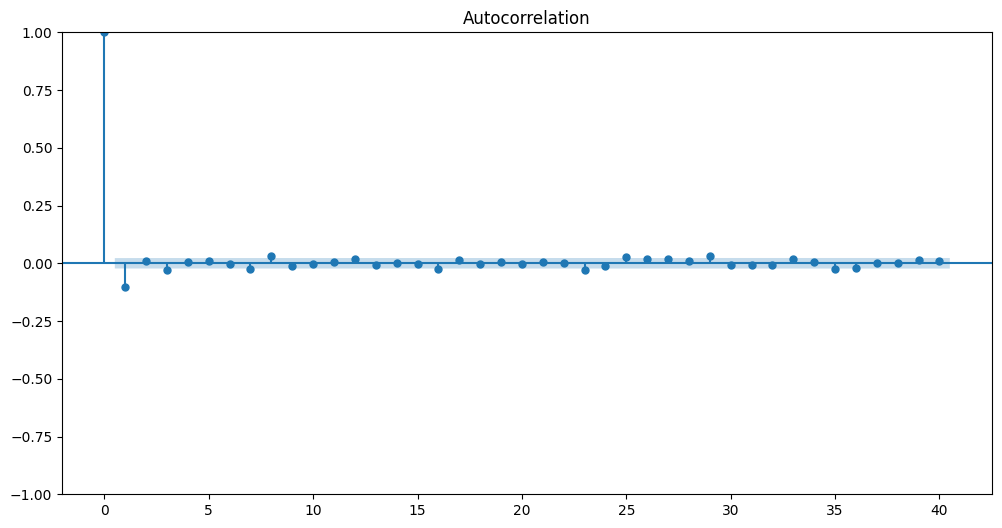

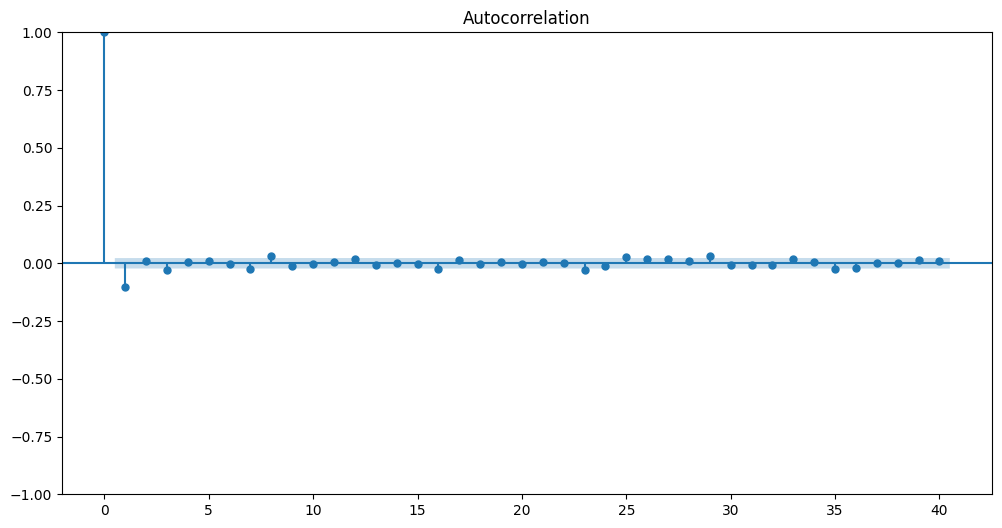

In [20]:
plt.figure(figsize=(12, 6))
plot_acf(exchange_rate_log_diff, lags=40, ax=plt.gca())



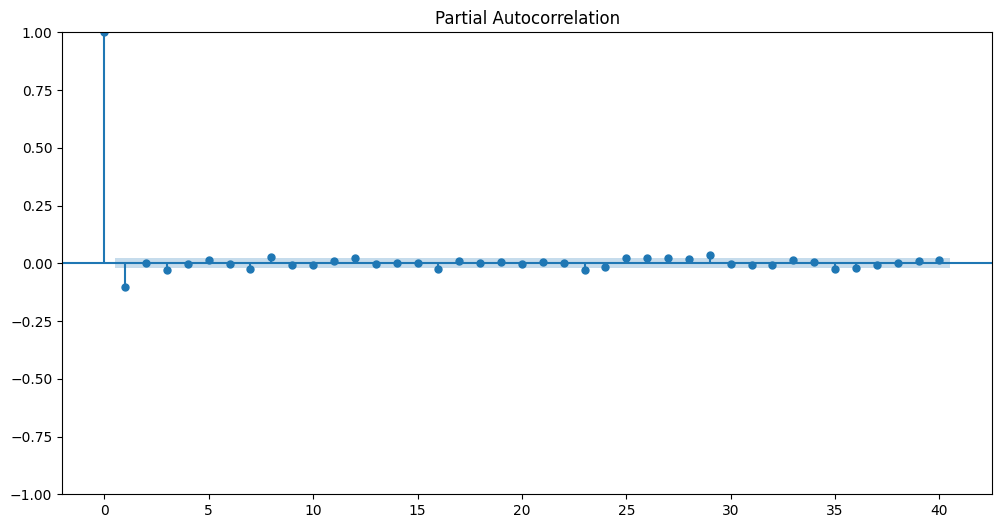

In [21]:
plt.figure(figsize=(12, 6))
plot_pacf(exchange_rate_log_diff, lags=40, ax=plt.gca())
plt.show()

## Splitting the Dataset into Training and Testing sets

In [22]:
train_size = int(len(data) * 0.8)


train_data, test_data = data['Ex_rate'][:train_size], data['Ex_rate'][train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")


Training set size: 6070
Testing set size: 1518


## Implementing the Arima Model

we got p,q,d values are(1,1,1)so using these values we are implementing the Arima Model.

In [23]:
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Wed, 02 Oct 2024   AIC                         -45432.092
Time:                        11:12:36   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

### Forecasting

In [24]:
model_fit.forecast(steps=20)

,predicted_mean
2006-08-15,1.023685
2006-08-16,1.023606
2006-08-17,1.023653
2006-08-18,1.023625
2006-08-19,1.023642
2006-08-20,1.023632
2006-08-21,1.023638
2006-08-22,1.023634
2006-08-23,1.023636
2006-08-24,1.023635


## Model Building - Exponential Smoothing

Using an additive Trend and No seasonal component

In [25]:
exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
exp_result = exp_smoothing_model.fit()

print(exp_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 6070
Model:             ExponentialSmoothing   SSE                              0.199
Optimized:                         True   AIC                         -62655.290
Trend:                         Additive   BIC                         -62628.446
Seasonal:                          None   AICC                        -62655.276
Seasonal Periods:                  None   Date:                 Wed, 02 Oct 2024
Box-Cox:                          False   Time:                         11:12:37
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9460679                alpha                 True
smoothing_trend           2.5147e-

### Forecasting

In [26]:
exp_result.forecast(steps=20)

,0
2006-08-15,1.023559
2006-08-16,1.023577
2006-08-17,1.023594
2006-08-18,1.023611
2006-08-19,1.023628
2006-08-20,1.023645
2006-08-21,1.023662
2006-08-22,1.023680
2006-08-23,1.023697
2006-08-24,1.023714


## Evaluation and Comparison of Both Models

In [28]:
Arima_forecast = model_fit.forecast(steps=len(test_data))
print(Arima_forecast)

2006-08-15    1.023685
2006-08-16    1.023606
2006-08-17    1.023653
2006-08-18    1.023625
2006-08-19    1.023642
                ...   
2010-10-06    1.023636
2010-10-07    1.023636
2010-10-08    1.023636
2010-10-09    1.023636
2010-10-10    1.023636
Freq: D, Name: predicted_mean, Length: 1518, dtype: float64


In [29]:
Exponential_forecast = exp_result.forecast(steps=len(test_data))
print(Exponential_forecast)

2006-08-15    1.023559
2006-08-16    1.023577
2006-08-17    1.023594
2006-08-18    1.023611
2006-08-19    1.023628
                ...   
2010-10-06    1.049521
2010-10-07    1.049538
2010-10-08    1.049555
2010-10-09    1.049572
2010-10-10    1.049589
Freq: D, Length: 1518, dtype: float64


## Model Comparison:

In [30]:
arima_mae = mean_absolute_error(test_data,Arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data, Arima_forecast))

print(f'Arima_MAE: {arima_mae}')
print(f'Arima_RMSE: {arima_rmse}')
print()

exp_mae = mean_absolute_error(test_data,Exponential_forecast)
exp_rmse = np.sqrt(mean_squared_error(test_data,Exponential_forecast))

print(f'Exponential_MAE: {exp_mae}')
print(f'Exponential_RMSE: {exp_rmse}')


Arima_MAE: 0.17770970449121345
Arima_RMSE: 0.2054366965966928

Exponential_MAE: 0.19027267219127425
Exponential_RMSE: 0.22008426144336735


## Interpretation

**MAE:**

The ARIMA model has a slightly lower MAE (0.1777) compared to the Exponential Smoothing model (0.1903), indicating that, on average, ARIMA makes smaller errors in its predictions.

**RMSE:**

 Similarly, the ARIMA model has a lower RMSE (0.2054) than the Exponential Smoothing model (0.2201), meaning that the ARIMA model is less sensitive to large errors.

## Conclusion

ARIMA performs better than the Exponential Smoothing model for this particular dataset. It has both a lower MAE and RMSE, which suggests that its predictions are more accurate and it is less affected by larger errors compared to the Exponential Smoothing model.


Since RMSE is more sensitive to large errors, the lower RMSE in the ARIMA model indicates it handles outliers or larger deviations better than the Exponential Smoothing model.